In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28)).astype(np.float32) / 255.0
x_test = x_test.reshape((-1, 28 * 28)).astype(np.float32) / 255.0

In [37]:
# RBM parameters
num_visible = 28 * 28  # Number of visible units
num_hidden = 128      # Number of hidden units

In [30]:
# Initialize RBM parameters
weights = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.1))
visible_bias = tf.Variable(tf.zeros([num_visible]))
hidden_bias = tf.Variable(tf.zeros([num_hidden]))

In [41]:
# Training parameters
learning_rate = 0.01
batch_size = 64
epochs = 30


# Training function using Contrastive Divergence
def train_step(v0_state):
    with tf.GradientTape() as tape:
        # Positive phase (compute hidden states given visible states)
        h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, weights) + hidden_bias)
        h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))

        # Negative phase (reconstruct visible states given hidden states)
        v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(weights)) + visible_bias)
        v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))

        # Compute gradients
        positive_grad = tf.matmul(tf.transpose(v0_state), h0_prob)
        negative_grad = tf.matmul(tf.transpose(v1_state), h0_prob)

        # Update weights and biases
        delta_weights = learning_rate * (positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(v0_state)[0], dtype=tf.float32)
        delta_visible_bias = learning_rate * tf.reduce_mean(v0_state - v1_state, 0)
        delta_hidden_bias = learning_rate * tf.reduce_mean(h0_prob - h0_state, 0)

        weights.assign_add(delta_weights)
        visible_bias.assign_add(delta_visible_bias)
        hidden_bias.assign_add(delta_hidden_bias)

        # Compute reconstruction loss
        loss = tf.reduce_mean(tf.square(v0_state - v1_state))

    return loss

In [42]:
# Training loop
for epoch in range(epochs):
    for batch_start in range(0, len(x_train), batch_size):
        batch_end = batch_start + batch_size
        v0_state = x_train[batch_start:batch_end]
        loss = train_step(v0_state)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}")

Epoch 1/30, Loss: 0.10177236795425415
Epoch 2/30, Loss: 0.1014067530632019
Epoch 3/30, Loss: 0.10075508803129196
Epoch 4/30, Loss: 0.1001773551106453
Epoch 5/30, Loss: 0.10147082805633545
Epoch 6/30, Loss: 0.10096266120672226
Epoch 7/30, Loss: 0.10083073377609253
Epoch 8/30, Loss: 0.10381928086280823
Epoch 9/30, Loss: 0.09781374037265778
Epoch 10/30, Loss: 0.09950786828994751
Epoch 11/30, Loss: 0.09780140221118927
Epoch 12/30, Loss: 0.10259988158941269
Epoch 13/30, Loss: 0.10141878575086594
Epoch 14/30, Loss: 0.0998450294137001
Epoch 15/30, Loss: 0.100229412317276
Epoch 16/30, Loss: 0.09944487363100052
Epoch 17/30, Loss: 0.10143112391233444
Epoch 18/30, Loss: 0.10015405714511871
Epoch 19/30, Loss: 0.10193367302417755
Epoch 20/30, Loss: 0.10015203803777695
Epoch 21/30, Loss: 0.09890200197696686
Epoch 22/30, Loss: 0.0994047075510025
Epoch 23/30, Loss: 0.09863892197608948
Epoch 24/30, Loss: 0.09938749670982361
Epoch 25/30, Loss: 0.10072710365056992
Epoch 26/30, Loss: 0.10062284022569656
E

In [46]:
# Reconstruct images
num_samples = 10
sample_indices = np.random.randint(0, len(x_test), num_samples)
samples = x_test[sample_indices]


In [47]:
# Reconstruction
h_prob = tf.nn.sigmoid(tf.matmul(samples, weights) + hidden_bias)
h_state = tf.nn.relu(tf.sign(h_prob - tf.random.uniform(tf.shape(h_prob))))
v_prob = tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(weights)) + visible_bias)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob))))

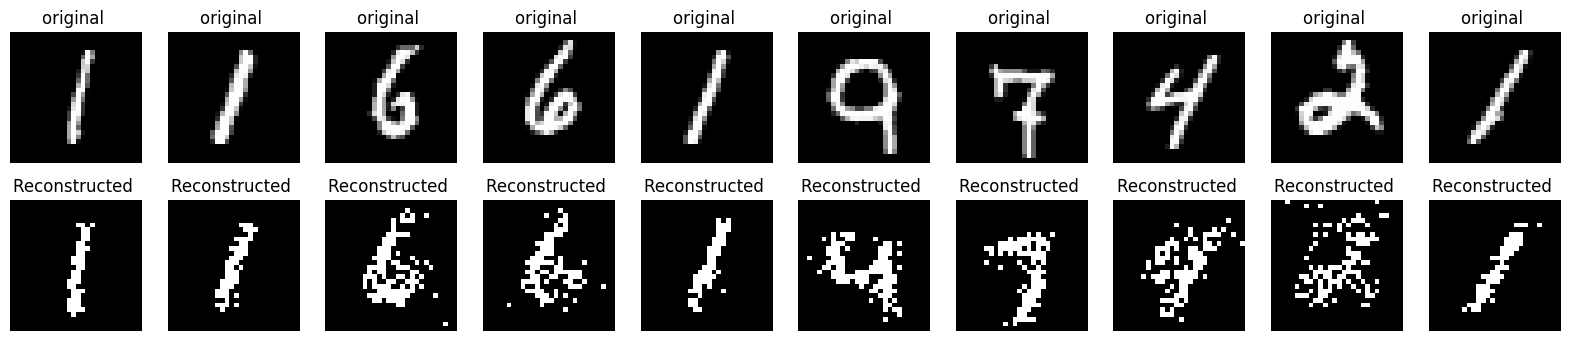

In [51]:
# Visualize original and reconstructed images
plt.figure(figsize=(num_samples * 2, 4))
for i in range(num_samples):
    # Original Image
    plt.subplot(2, num_samples, i + 1)
    plt.title('original ')
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.title('Reconstructed ' )
    plt.imshow(v_state[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()